In [1]:
import math
import random
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from src.mst.pamst import pamst, comp_mst_weight
from src.mst.mst_utilities import compute_real_mst_weight, generate_random_complete_graph, compute_input_perturbation

sns.set_theme(font_scale=1.5, rc={'text.usetex' : True})



In [14]:
# Computing Private Minimum Spanning Trees using Different Algorithms

# Privacy Parameters
rho_values = [0.1,0.015,0.2,0.375,0.5,1,2,4,6,10]
n = 100
sensitivity = 1

# Generate a enw graph
G = generate_random_complete_graph(n)
print("Generated " + str(G))

### Real Spanning Tree ###

    # Simply make an array to make visualization easier
real_weights = [compute_real_mst_weight(G)] * len(rho_values) 
print("Real MST Weight: " + str(real_weights[0]))

### Pinot's PAMST Algorithm ###

pamst_weights = []
for rho in rho_values:
    noise_level = (2 * sensitivity * math.sqrt(n-1))/(math.sqrt(2 * rho))
    pamst_edges = pamst(G, noise_level) # Gives an iterator which should only be executed once!
    pamst_weights += [comp_mst_weight(pamst_edges)]
#    print("PAMST MST Weight: " + str(pamst_weight))


### Sealfon's Post Processing Technique ###

sealfon_weights = []
for rho in rho_values:
    noise_level = 1/rho # TODO FIX LEVEL
    sealfon_weights += [compute_input_perturbation(G, noise_level, random.gauss)]
    # print("Sealfon MST Weight: " + str(weight_sealfon))

### Finally: Our Approach ###
our_weights = []
for rho in rho_values:
    noise_level = 1/rho # TODO FIX LEVEL
    our_weights += [compute_input_perturbation(G, noise_level, random.gauss)]
    # print("Our MST Weight: " + str(weight_sealfon))

print(sealfon_weights)


## TODO Privacy / utility Tradeoff Curves.
## TODO Select Graph Classes we want to do experiments on.

Generated Graph with 100 nodes and 4950 edges
Real MST Weight: 1.175590612472249
[48.56424695949828, 46.075191737943044, 41.72924626208628, 45.86061852790747, 38.96467229399083, 32.672894021696465, 21.936433028318884, 10.839400476667485, 9.705518298437793, 5.617670727050895]


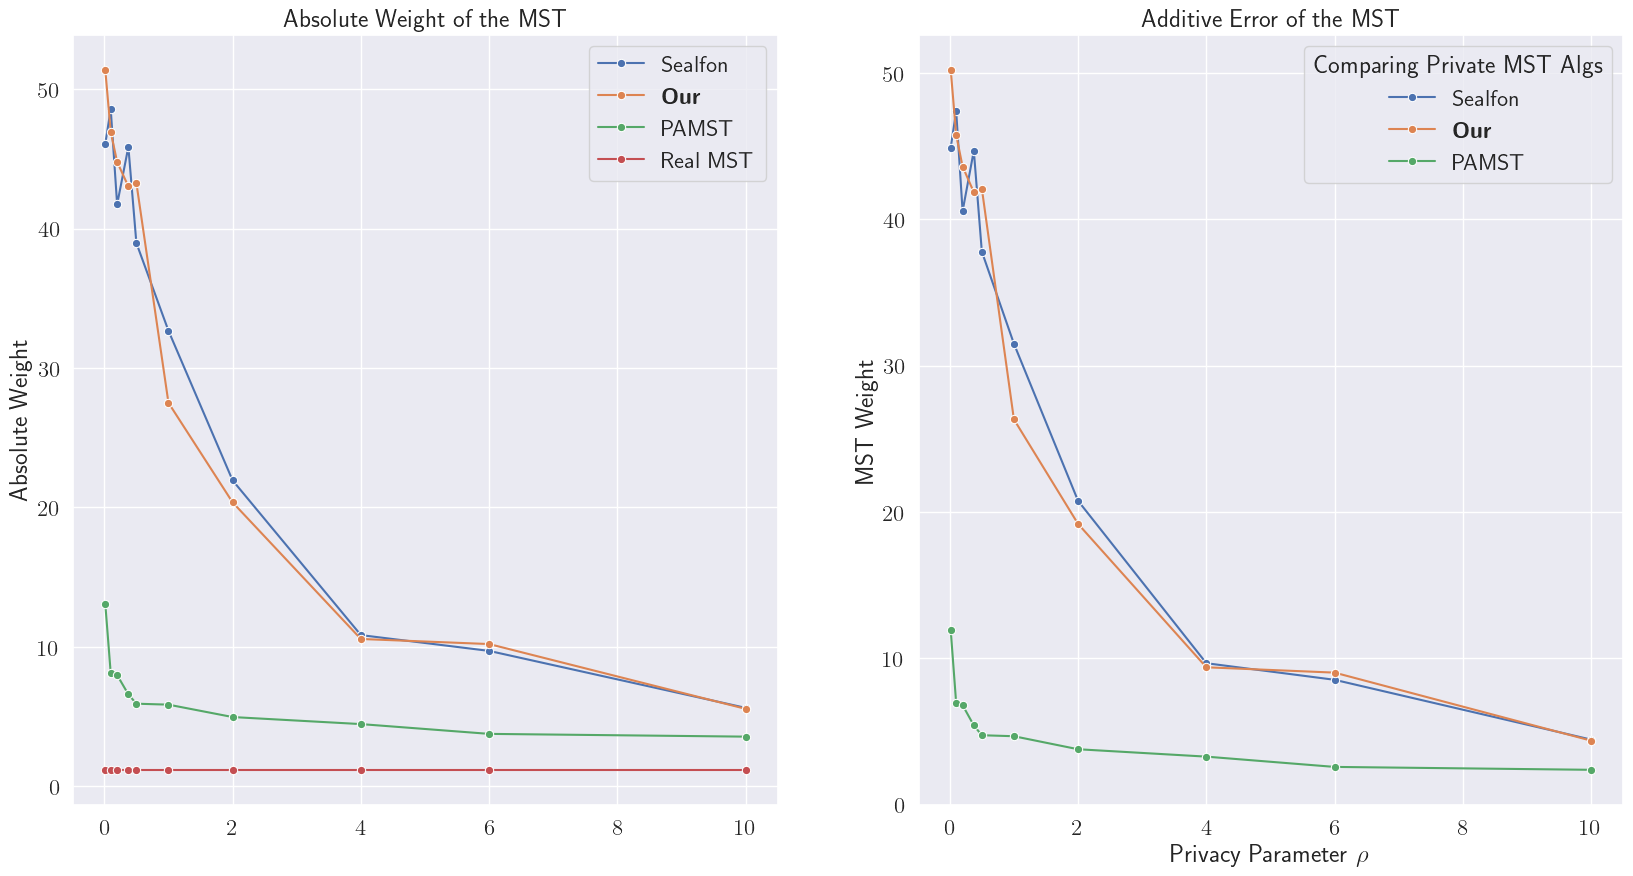

In [36]:
# Visualizing the results

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid

# Error of the MST
sns.lineplot(x= rho_values, y=sealfon_weights,marker='o', label="Sealfon", ax=axs[0])
sns.lineplot(x= rho_values, y=our_weights, marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x= rho_values, y=pamst_weights, marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x= rho_values, y=real_weights, marker='o', label="Real MST", ax=axs[0])
axs[0].set_title("Absolute Weight of the MST")

# Error of the MST
sns.lineplot(x= rho_values, y=[sealfon - real for sealfon, real in zip(sealfon_weights, real_weights)] ,marker='o', label="Sealfon", ax=axs[1])
sns.lineplot(x= rho_values, y=[ours - real for ours, real in zip(our_weights, real_weights)] , marker='o', label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x= rho_values, y=[pamst - real for pamst, real in zip(pamst_weights, real_weights)] , marker='o', label="PAMST", ax=axs[1])
axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
plt.ylabel("MST Weight")
plt.legend(title = "Comparing Private MST Algs")
plt.show()
